# Excitation inhibition balance


In [1]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline

np.set_printoptions(suppress=True, precision=2)

sns.set(font_scale=2.0)

#### Git machinery

In [2]:
run_old_version = False
if run_old_version:
    hash_when_file_was_written = '95c0ca0cdca3f00e55f0e46dd9a8b8c1f492d94e'
    hash_at_the_moment = subprocess.check_output(["git", 'rev-parse', 'HEAD']).strip()
    print('Actual hash', hash_at_the_moment)
    
    print('Hash of the commit used to run the simulation', hash_when_file_was_written)
    subprocess.call(['git', 'checkout', hash_when_file_was_written])

In [3]:
from network import Protocol, BCPNNFast, NetworkManager
from analysis_functions import calculate_recall_success_sequences, calculate_excitation_inhibition_ratio
from plotting_functions import plot_weight_matrix

## Initial exploration

Run the example

In [4]:
# Patterns parameters
hypercolumns = 4
minicolumns = 20
n_patterns = 10

dt = 0.001

values_to_save = ['o']

# Recall
n = 1
T_cue = 0.100
T_recall = 10.0

# Protocol
training_time = 0.1
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 3

# Build the network
tau_z_pre = 0.150
nn = BCPNNFast(hypercolumns, minicolumns, tau_z_pre=tau_z_pre)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

protocol = Protocol()
sequences = [i for i in range(n_patterns)]
protocol.simple_protocol(patterns_indexes=sequences, training_time=training_time,
                         inter_sequence_interval=inter_sequence_interval, epochs=epochs)


manager.run_network_protocol(protocol=protocol, verbose=False)

#### Analysis 

In [5]:
# Data analysis
w_ampa = nn.w_ampa
w_nmda = nn.w

w = np.copy(w_nmda)

remove_inter = False
if remove_inter:
    for i in range(hypercolumns):
        for j in range(hypercolumns):
            index1 = minicolumns * j
            index2 = minicolumns * i
            indexes1  = [index1 + k for k in range(n_patterns)]
            indexes2 = [index2 + k for k in range(n_patterns)]
            w[indexes1, indexes2] = 0

sequence_element = sequences[0]
total_connectivity_weights = w[sequence_element, :]
indexes = total_connectivity_weights > 0
excitation = total_connectivity_weights[indexes]
inhibition = total_connectivity_weights[np.logical_not(indexes)]

print('total excitaiton', np.sum(excitation))
print('total inhibition', np.sum(inhibition))

('total excitaiton', 17.752808842057693)
('total inhibition', -38.719479346690377)


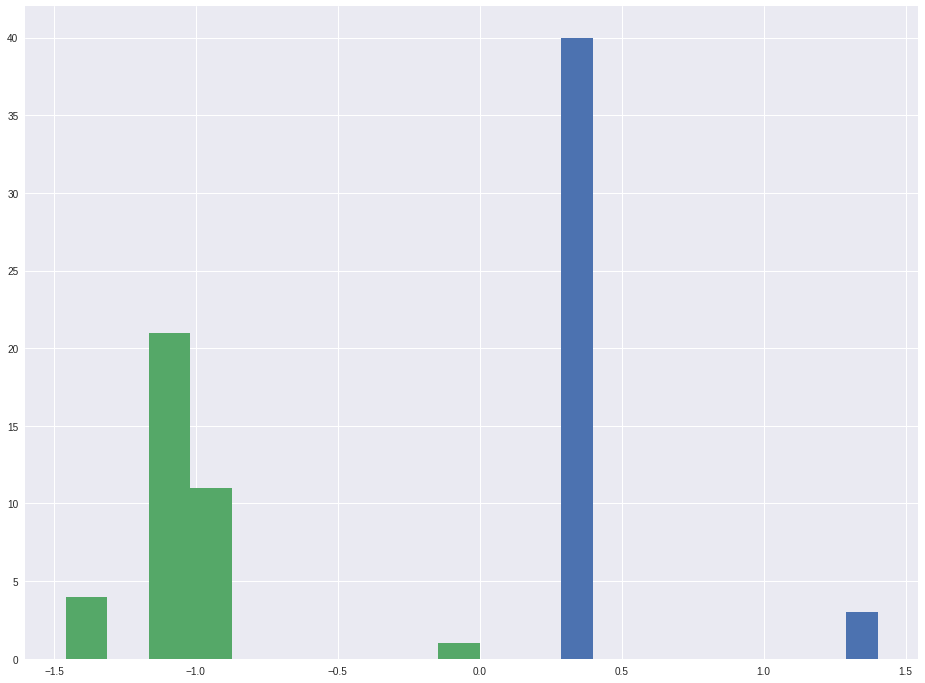

In [6]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.hist(excitation, label='excitation')
ax.hist(inhibition, label='inhibition');

In [7]:
def remove_auto_influence(hypercolumns, minicolumns,w , n_patterns):
    for i in range(hypercolumns):
        for j in range(hypercolumns):
            index1 = minicolumns * j
            index2 = minicolumns * i
            indexes1  = [index1 + k for k in range(n_patterns)]
            indexes2 = [index2 + k for k in range(n_patterns)]
            w[indexes1, indexes2] = 0
            
            
# You see that
def get_excitation(index, w):
    sequence_element = sequences[index]
    total_connectivity_weights = w[sequence_element, :]
    exc_indexes = total_connectivity_weights > 0
    excitation = total_connectivity_weights[exc_indexes]
    
    return excitation

def get_inhibition(index, w):
    sequence_element = sequences[index]
    total_connectivity_weights = w[sequence_element, :]
    inh_indexes = total_connectivity_weights < 0
    inhibition = total_connectivity_weights[inh_indexes]
    
    return inhibition

In [8]:
w_ampa = nn.w_ampa
w_nmda = nn.w

w = np.copy(w_nmda)

total_exc = []
total_inh = []

indexes = np.arange(1, n_patterns - 1, dtype='int')
for index in indexes:
    excitation = get_excitation(index, w)
    inhibition = get_inhibition(index, w)
    
    total_exc.append(np.sum(excitation))
    total_inh.append(np.sum(inhibition))

ratio = np.sum(total_exc) / -np.sum(total_inh)
print('ratio', ratio)

('ratio', 0.25453971872050074)


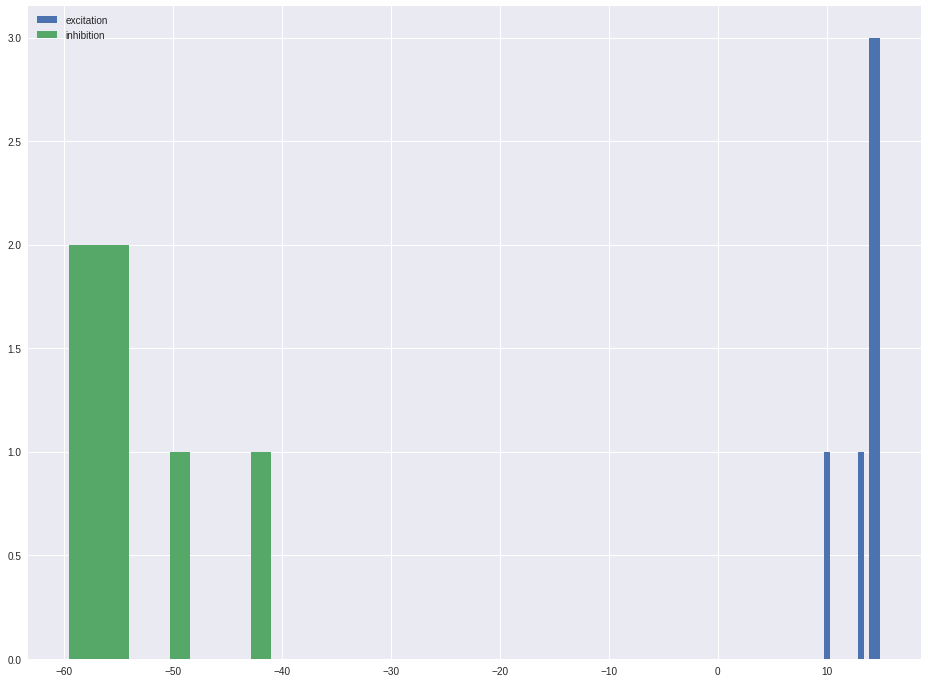

In [9]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.hist(total_exc, label='excitation')
ax.hist(total_inh, label='inhibition')

ax.legend();

In [10]:
def calculate_excitation_inhibition_ratio2(nn, hypercolumns, minicolumns, indexes, ampa=False):
    if ampa:
        w_use = nn.w_ampa
    else:
        w_use = nn.w

    w = np.copy(w_use)

    total_exc = []
    total_inh = []

   
    for index in indexes:
        excitation = get_excitation(index, w)
        inhibition = get_inhibition(index, w)

        total_exc.append(np.sum(excitation))
        total_inh.append(np.sum(inhibition))

    ratio = np.sum(total_exc) / -np.sum(total_inh)
    
    return ratio

In [11]:
indexes = np.arange(1, n_patterns, dtype='int')
ratio_nmda = calculate_excitation_inhibition_ratio2(nn, hypercolumns, minicolumns, indexes, ampa=False)
ratio_ampa = calculate_excitation_inhibition_ratio2(nn, hypercolumns, minicolumns, indexes, ampa=True)

print('nmda ratio', ratio_nmda)
print('ampa ratio', ratio_ampa)

('nmda ratio', 0.23635685772947923)
('ampa ratio', 0.089949255567180836)


Now we use the function that we build specially for it and store in analysis functions

In [12]:
ratio_nmda = calculate_excitation_inhibition_ratio(nn, sequences, ampa=False)
ratio_ampa = calculate_excitation_inhibition_ratio(nn, sequences, ampa=True)

print('nmda ratio', ratio_nmda[0])
print('ampa ratio', ratio_ampa[0])

('nmda ratio', 0.26379600684800408)
('ampa ratio', 0.091061920508488853)


## Paramater study

### Structure parameters
#### n_patterns

In [13]:
# Patterns parameters
hypercolumns = 4
minicolumns = 40
n_patterns = 10

dt = 0.001

values_to_save = ['o']

# Recall
n = 1
T_cue = 0.100
T_recall = 10.0

# Protocol
training_time = 0.1
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 3

# Build the network
tau_z_pre = 0.150
tau_a = 2.70

In [14]:
n_patterns_range = np.arange(5, 25, 5)
nmda_ratio_n_patterns = []
ampa_ratio_n_patterns = []
success_n_patterns = []

for n_patterns in n_patterns_range:
    nn = BCPNNFast(hypercolumns, minicolumns, tau_z_pre=tau_z_pre)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    protocol = Protocol()
    sequences = [i for i in range(n_patterns)]
    protocol.simple_protocol(patterns_indexes=sequences, training_time=training_time,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)


    manager.run_network_protocol(protocol=protocol, verbose=False)
    
    ratio_nmda = calculate_excitation_inhibition_ratio(nn, sequences, ampa=False)[0]
    ratio_ampa = calculate_excitation_inhibition_ratio(nn, sequences, ampa=True)[0]
    
    successes = calculate_recall_success_sequences(manager, T_recall=T_recall, 
                                                   T_cue=T_cue, n=n, sequences=[sequences])
    
    # Store everything
    nmda_ratio_n_patterns.append(ratio_nmda)
    ampa_ratio_n_patterns.append(ratio_ampa)
    success_n_patterns.append(successes[0])

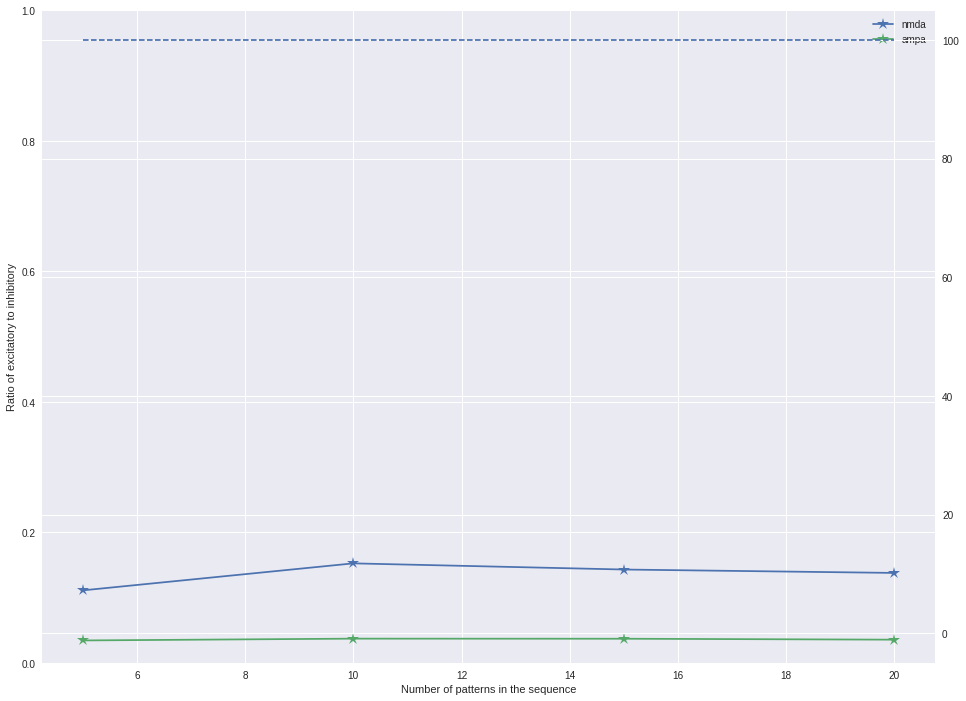

In [15]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(n_patterns_range, nmda_ratio_n_patterns, '*-', markersize=13, label='nmda')
ax.plot(n_patterns_range, ampa_ratio_n_patterns, '*-', markersize=13, label='ampa')

ax2 = ax.twinx()
ax2.plot(n_patterns_range, success_n_patterns, '--', label='success')
ax2.set_ylim([-5, 105])

ax.set_xlabel('Number of patterns in the sequence')
ax.set_ylabel('Ratio of excitatory to inhibitory')

ax.set_ylim([0, 1])
ax.legend();

#### Minicolumns

In [16]:
# Patterns parameters
hypercolumns = 4
minicolumns = 40
n_patterns = 10

dt = 0.001

values_to_save = ['o']

# Recall
n = 1
T_cue = 0.100
T_recall = 10.0

# Protocol
training_time = 0.1
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 3

# Build the network
tau_z_pre = 0.150
tau_a = 2.70

In [17]:
minicolumns_range = np.arange(15, 45, 5)
nmda_ratio_minicolumns = []
ampa_ratio_minicolumns = []
success_minicolumns = []

for minicolumns in minicolumns_range:
    nn = BCPNNFast(hypercolumns, minicolumns, tau_z_pre=tau_z_pre)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    protocol = Protocol()
    sequences = [i for i in range(n_patterns)]
    protocol.simple_protocol(patterns_indexes=sequences, training_time=training_time,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)


    manager.run_network_protocol(protocol=protocol, verbose=False)
    
    ratio_nmda = calculate_excitation_inhibition_ratio(nn, sequences, ampa=False)[0]
    ratio_ampa = calculate_excitation_inhibition_ratio(nn, sequences, ampa=True)[0]
    
    successes = calculate_recall_success_sequences(manager, T_recall=T_recall, 
                                                   T_cue=T_cue, n=n, sequences=[sequences])
    
    # Store everything
    nmda_ratio_minicolumns.append(ratio_nmda)
    ampa_ratio_minicolumns.append(ratio_ampa)
    success_minicolumns.append(successes[0])

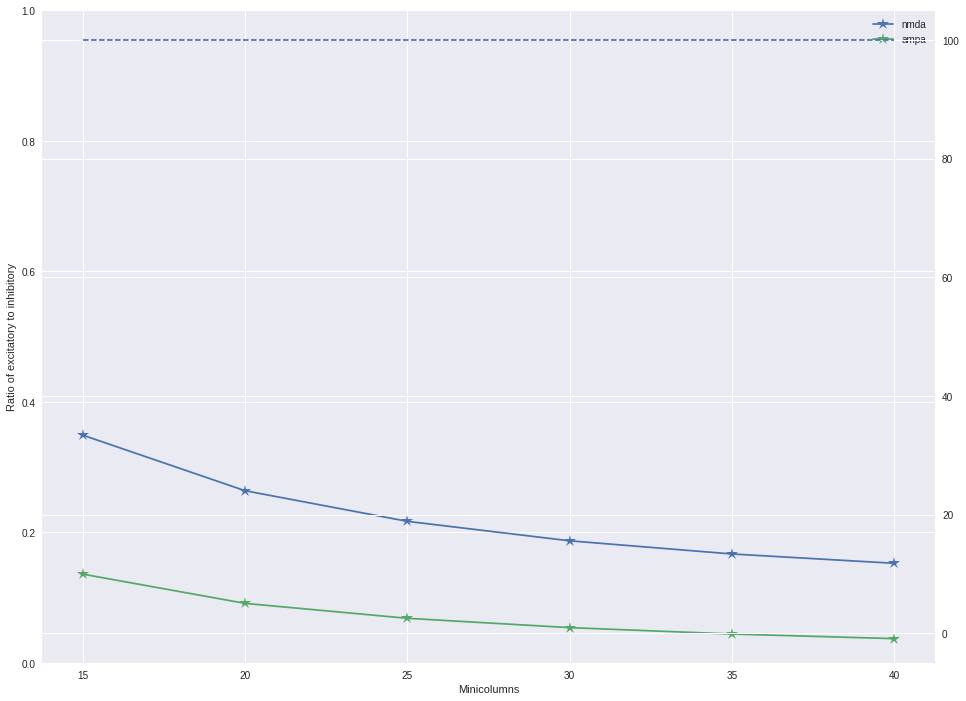

In [18]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(minicolumns_range, nmda_ratio_minicolumns, '*-', markersize=13, label='nmda')
ax.plot(minicolumns_range, ampa_ratio_minicolumns, '*-', markersize=13, label='ampa')

ax2 = ax.twinx()
ax2.plot(minicolumns_range, success_minicolumns, '--', label='success')
ax2.set_ylim([-5, 105])

ax.set_xlabel('Minicolumns')
ax.set_ylabel('Ratio of excitatory to inhibitory')

ax.set_ylim([0, 1])
ax.legend();

#### Hypercolumns

In [19]:
# Patterns parameters
hypercolumns = 4
minicolumns = 40
n_patterns = 10

dt = 0.001

values_to_save = ['o']

# Recall
n = 1
T_cue = 0.100
T_recall = 10.0

# Protocol
training_time = 0.1
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 3

# Build the network
tau_z_pre = 0.150
tau_a = 2.70

In [20]:
hypercolumns_range = np.arange(3, 12, 2)
nmda_ratio_hypercolumns = []
ampa_ratio_hypercolumns = []
success_hypercolumns = []

for hypercolumns in hypercolumns_range:
    nn = BCPNNFast(hypercolumns, minicolumns, tau_z_pre=tau_z_pre)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    protocol = Protocol()
    sequences = [i for i in range(n_patterns)]
    protocol.simple_protocol(patterns_indexes=sequences, training_time=training_time,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)


    manager.run_network_protocol(protocol=protocol, verbose=False)
    
    ratio_nmda = calculate_excitation_inhibition_ratio(nn, sequences, ampa=False)[0]
    ratio_ampa = calculate_excitation_inhibition_ratio(nn, sequences, ampa=True)[0]
   
    successes = calculate_recall_success_sequences(manager, T_recall=T_recall, 
                                                   T_cue=T_cue, n=n, sequences=[sequences])
    
    # Store everything
    nmda_ratio_hypercolumns.append(ratio_nmda)
    ampa_ratio_hypercolumns.append(ratio_ampa)
    success_hypercolumns.append(successes[0])

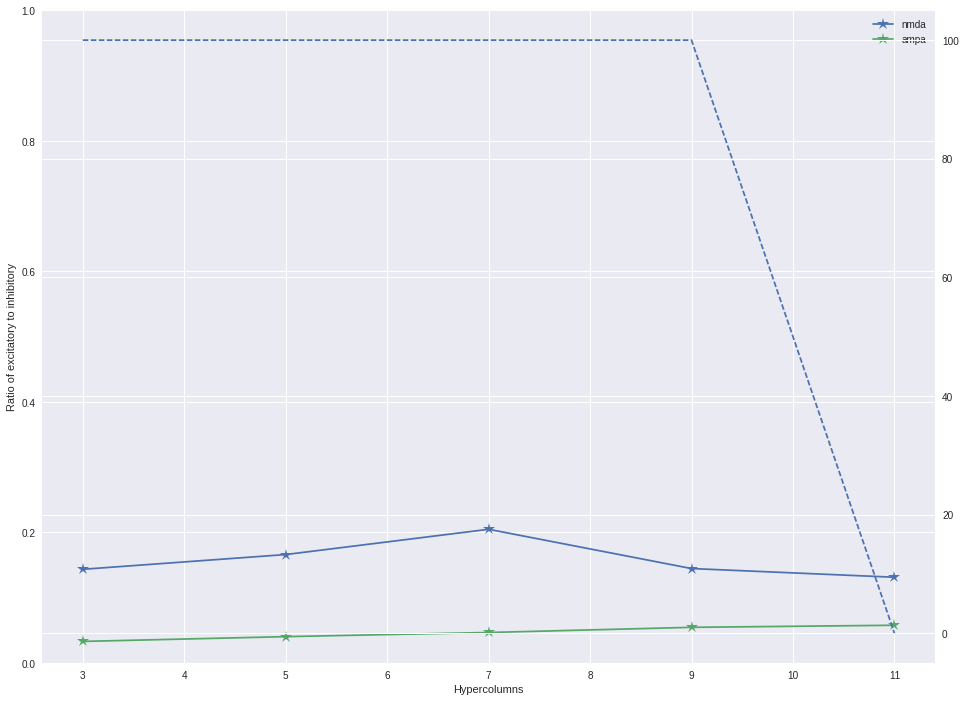

In [21]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(hypercolumns_range, nmda_ratio_hypercolumns, '*-', markersize=13, label='nmda')
ax.plot(hypercolumns_range, ampa_ratio_hypercolumns, '*-', markersize=13, label='ampa')

ax2 = ax.twinx()
ax2.plot(hypercolumns_range, success_hypercolumns, '--', label='success')
ax2.set_ylim([-5, 105])

ax.set_xlabel('Hypercolumns')
ax.set_ylabel('Ratio of excitatory to inhibitory')

ax.set_ylim([0, 1])
ax.legend();

### Training parameters
#### Epochs

In [22]:
# Patterns parameters
hypercolumns = 4
minicolumns = 40
n_patterns = 10

dt = 0.001

values_to_save = ['o']

# Recall
n = 1
T_cue = 0.100
T_recall = 10.0

# Protocol
training_time = 0.1
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 3

# Build the network
tau_z_pre = 0.150
tau_a = 2.70

In [23]:
epochs_range = np.arange(1, 11, 2)
nmda_ratio_epochs = []
ampa_ratio_epochs  = []
success_epochs  = []

for epochs  in epochs_range:
    nn = BCPNNFast(hypercolumns, minicolumns, tau_z_pre=tau_z_pre)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    protocol = Protocol()
    sequences = [i for i in range(n_patterns)]
    protocol.simple_protocol(patterns_indexes=sequences, training_time=training_time,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)


    manager.run_network_protocol(protocol=protocol, verbose=False)
    
    ratio_nmda = calculate_excitation_inhibition_ratio(nn, sequences, ampa=False)[0]
    ratio_ampa = calculate_excitation_inhibition_ratio(nn, sequences, ampa=True)[0]
    
    successes = calculate_recall_success_sequences(manager, T_recall=T_recall, 
                                                   T_cue=T_cue, n=n, sequences=[sequences])
    
    # Store everything
    nmda_ratio_epochs.append(ratio_nmda)
    ampa_ratio_epochs.append(ratio_ampa)
    success_epochs.append(successes[0])

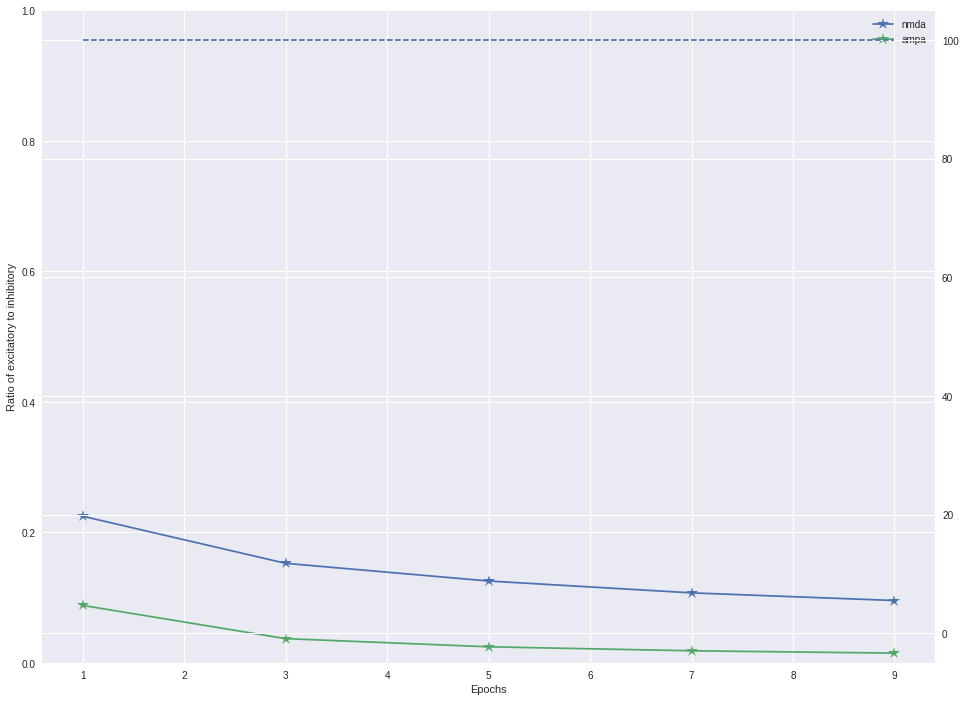

In [24]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(epochs_range, nmda_ratio_epochs , '*-', markersize=13, label='nmda')
ax.plot(epochs_range, ampa_ratio_epochs , '*-', markersize=13, label='ampa')

ax2 = ax.twinx()
ax2.plot(epochs_range, success_epochs , '--', label='success')
ax2.set_ylim([-5, 105])

ax.set_xlabel('Epochs')
ax.set_ylabel('Ratio of excitatory to inhibitory')

ax.set_ylim([0, 1])
ax.legend();

#### Training time

In [25]:
# Patterns parameters
hypercolumns = 4
minicolumns = 40
n_patterns = 10

dt = 0.001

values_to_save = ['o']

# Recall
n = 1
T_cue = 0.100
T_recall = 10.0

# Protocol
training_time = 0.1
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 3

# Build the network
tau_z_pre = 0.150
tau_a = 2.70

In [26]:
training_time_range = np.arange(0.050,0.450, 0.050)
nmda_ratio_training_time = []
ampa_ratio_training_time  = []
success_training_time  = []

for training_time  in training_time_range:
    nn = BCPNNFast(hypercolumns, minicolumns, tau_z_pre=tau_z_pre)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    protocol = Protocol()
    sequences = [i for i in range(n_patterns)]
    protocol.simple_protocol(patterns_indexes=sequences, training_time=training_time,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)


    manager.run_network_protocol(protocol=protocol, verbose=False)
    
    ratio_nmda = calculate_excitation_inhibition_ratio(nn, sequences, ampa=False)[0]
    ratio_ampa = calculate_excitation_inhibition_ratio(nn, sequences, ampa=True)[0]
    
    successes = calculate_recall_success_sequences(manager, T_recall=T_recall, 
                                                   T_cue=T_cue, n=n, sequences=[sequences])
    
    # Store everything
    nmda_ratio_training_time.append(ratio_nmda)
    ampa_ratio_training_time.append(ratio_ampa)
    success_training_time.append(successes[0])

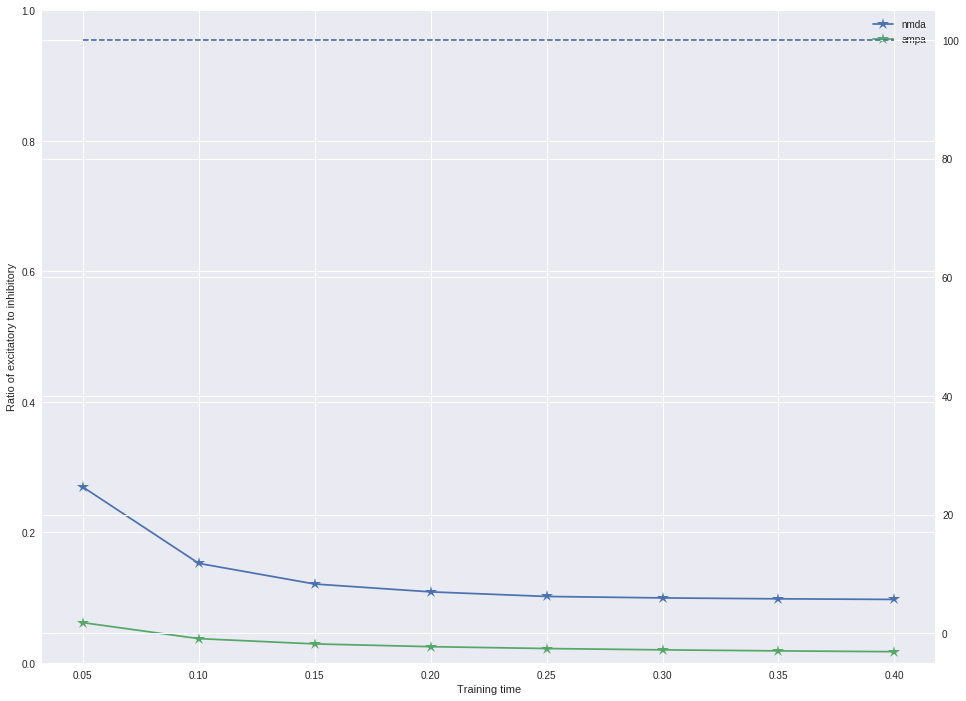

In [27]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(training_time_range, nmda_ratio_training_time , '*-', markersize=13, label='nmda')
ax.plot(training_time_range, ampa_ratio_training_time , '*-', markersize=13, label='ampa')

ax2 = ax.twinx()
ax2.plot(training_time_range, success_training_time , '--', label='success')
ax2.set_ylim([-5, 105])

ax.set_xlabel('Training time')
ax.set_ylabel('Ratio of excitatory to inhibitory')

ax.set_ylim([0, 1])
ax.legend();

### System parameters
#### tau_z_nmda

In [28]:
# Patterns parameters
hypercolumns = 4
minicolumns = 40
n_patterns = 10

dt = 0.001

values_to_save = ['o']

# Recall
n = 1
T_cue = 0.100
T_recall = 10.0

# Protocol
training_time = 0.1
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 3

# Build the network
tau_z_pre = 0.150
tau_a = 2.70

In [29]:
tau_z_pre_range = np.arange(0.050,0.450, 0.050)
nmda_ratio_tau_z_pre = []
ampa_ratio_tau_z_pre  = []
success_tau_z_pre  = []

for tau_z_pre in tau_z_pre_range:
    nn = BCPNNFast(hypercolumns, minicolumns, tau_z_pre=tau_z_pre)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    protocol = Protocol()
    sequences = [i for i in range(n_patterns)]
    protocol.simple_protocol(patterns_indexes=sequences, training_time=training_time,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)


    manager.run_network_protocol(protocol=protocol, verbose=False)
    
    ratio_nmda = calculate_excitation_inhibition_ratio(nn, sequences, ampa=False)[0]
    ratio_ampa = calculate_excitation_inhibition_ratio(nn, sequences, ampa=True)[0]
    
    successes = calculate_recall_success_sequences(manager, T_recall=T_recall, 
                                                   T_cue=T_cue, n=n, sequences=[sequences])
    
    # Store everything
    nmda_ratio_tau_z_pre.append(ratio_nmda)
    ampa_ratio_tau_z_pre.append(ratio_ampa)
    success_tau_z_pre.append(successes[0])

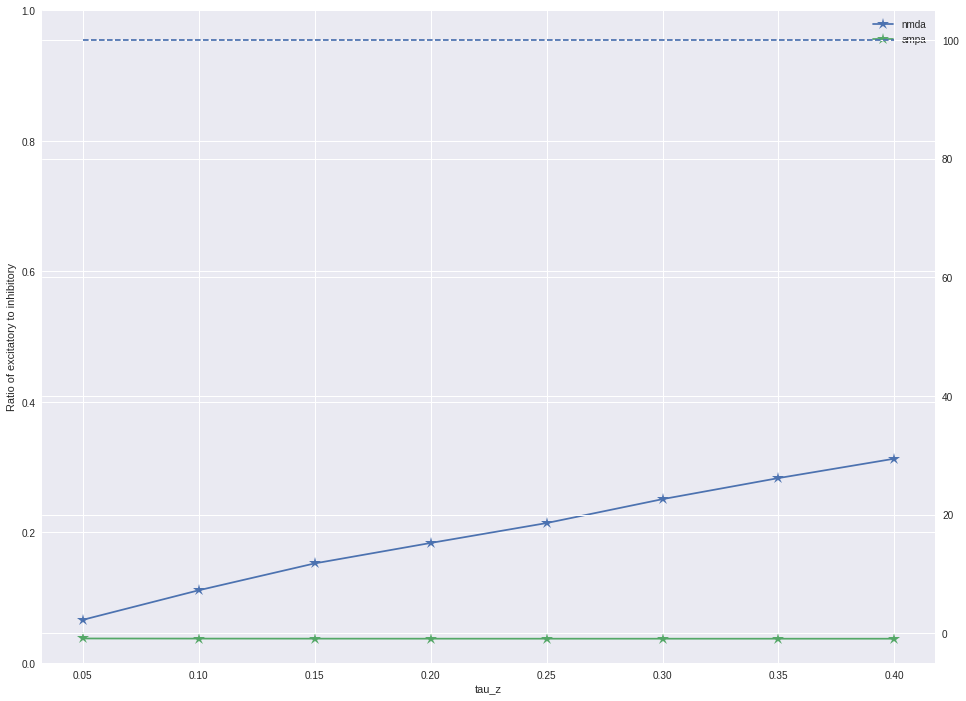

In [30]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(tau_z_pre_range, nmda_ratio_tau_z_pre , '*-', markersize=13, label='nmda')
ax.plot(tau_z_pre_range, ampa_ratio_tau_z_pre , '*-', markersize=13, label='ampa')

ax2 = ax.twinx()
ax2.plot(tau_z_pre_range, success_tau_z_pre , '--', label='success')
ax2.set_ylim([-5, 105])

ax.set_xlabel('tau_z')
ax.set_ylabel('Ratio of excitatory to inhibitory')

ax.set_ylim([0, 1])
ax.legend();

#### tau_a

In [31]:
# Patterns parameters
hypercolumns = 4
minicolumns = 40
n_patterns = 10

dt = 0.001

values_to_save = ['o']

# Recall
n = 1
T_cue = 0.100
T_recall = 10.0

# Protocol
training_time = 0.1
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 3

# Build the network
tau_z_pre = 0.150
tau_a = 2.70

In [32]:
tau_a_range = np.arange(0.100,0.600, 0.100)
nmda_ratio_tau_a = []
ampa_ratio_tau_a = []
success_tau_a = []

for tau_a in tau_a_range:
    nn = BCPNNFast(hypercolumns, minicolumns, tau_z_pre=tau_z_pre)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    protocol = Protocol()
    sequences = [i for i in range(n_patterns)]
    protocol.simple_protocol(patterns_indexes=sequences, training_time=training_time,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)


    manager.run_network_protocol(protocol=protocol, verbose=False)
    
    ratio_nmda = calculate_excitation_inhibition_ratio(nn, sequences, ampa=False)[0]
    ratio_ampa = calculate_excitation_inhibition_ratio(nn, sequences, ampa=True)[0]
    
    successes = calculate_recall_success_sequences(manager, T_recall=T_recall, 
                                                   T_cue=T_cue, n=n, sequences=[sequences])
    
    # Store everything
    nmda_ratio_tau_a.append(ratio_nmda)
    ampa_ratio_tau_a.append(ratio_ampa)
    success_tau_a.append(successes[0])

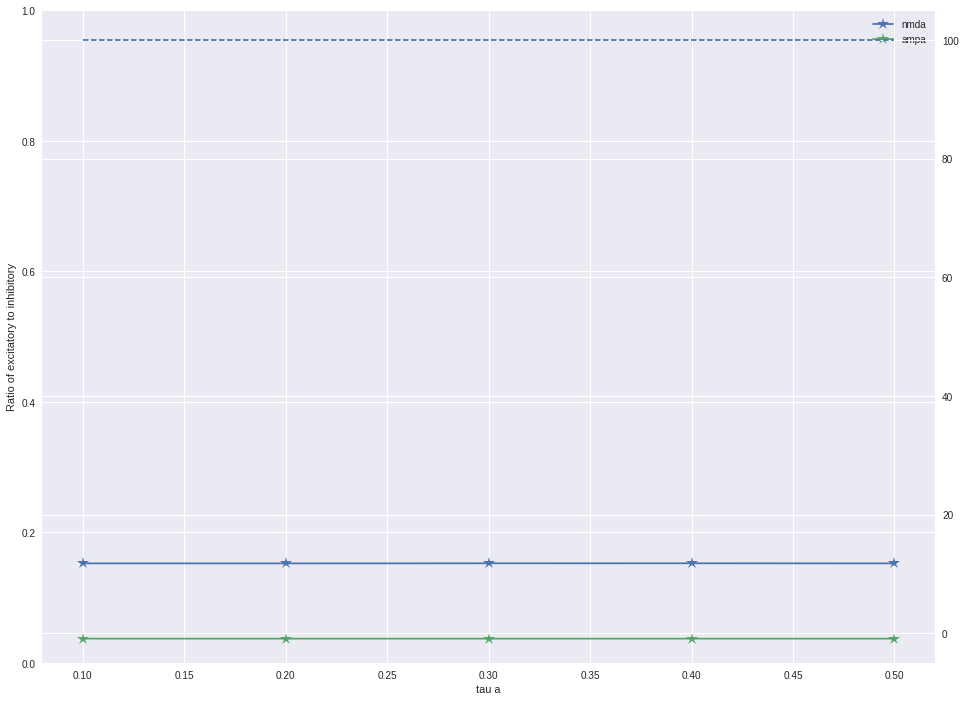

In [33]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(tau_a_range, nmda_ratio_tau_a , '*-', markersize=13, label='nmda')
ax.plot(tau_a_range, ampa_ratio_tau_a , '*-', markersize=13, label='ampa')

ax2 = ax.twinx()
ax2.plot(tau_a_range, success_tau_a , '--', label='success')
ax2.set_ylim([-5, 105])

ax.set_xlabel('tau a')
ax.set_ylabel('Ratio of excitatory to inhibitory')

ax.set_ylim([0, 1])
ax.legend();

#### Git machinery

In [34]:
if run_old_version:
    subprocess.call(['git', 'checkout', 'master'])